In [1]:
import ray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_cli
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import log_loss


In [2]:
def load_targets(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        
    transactions = {}
    for line in lines:
        line = line.split()
        drug, targets = line[0][:-1], line[1:]
        
        transactions[drug] = set(targets)
    return transactions

In [3]:
def transpose(itemsets: dict[str, set]):
    itemsetsT = {}
    for key, items in itemsets.items():
        for item in items:
            itemsetsT.setdefault(item, set()).add(key)
    return itemsetsT

In [4]:
import networkx as nx

def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=G.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

In [5]:
def build_graph_from_dict(item_sets):
    items, sets = item_sets.keys(), item_sets.values()
    items = list(items)
    sets = list(sets)
    
    N = len(items)
    graph = np.zeros((N,N))
    
    for i, s in tqdm(enumerate(sets), total=N):    
        for j in range(i+1, N):
            link_weight = len( s&sets[j] )
            if link_weight!=0:
                graph[i,j]+=link_weight

    return graph+graph.T

In [6]:
def jaccard_sim(bin_set_a, bin_set_b):
    a =np.inner(bin_set_a, bin_set_b)
    bc=np.sum(bin_set_a + bin_set_b)-a
    return a/bc

In [6]:
def prob(x):
    return 1 - np.exp(-x)

In [7]:
def rand(shape, min_=0, max_=1):
    return np.random.uniform(low=min_, high=max_, size=shape)

In [8]:
def get_F(shape, min_=0, max_=1):
    """
    Generates a random F matrix 
    """
    
    F = rand(shape, min_, max_)
    return F

In [9]:
def log_likelihood(fu, f_sum, fv_conns):
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [10]:
@ray.remote
def big_clam(F_shape, conns, orig_graph, hold_out_idx, LR=0.001, n_iters=1000, α = 1e-8, MAX_VALUE=None):
    N,K = F_shape
    F = get_F(F_shape)
    nodes = np.arange(NN, dtype=int)
    
    f_sum = F.sum(axis=0)
    init_ll = np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    
    
    for i in range(n_iters): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)

        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = prob(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad

            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
        if i%1000 == 0:
            print(f"{K} communities -- iteration {i} finished")
            
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    
    predicted_graph = get_graph_from_communities(F)
    hold_out_ll = log_loss(
        orig_graph[hold_out_idx], 
        predicted_graph[hold_out_idx], 
        labels=(0,1)
    )
    
    graph_ll = log_loss(
        orig_graph.flatten(), 
        predicted_graph.flatten(),
        labels=(0,1)
    )
    return init_ll, final_ll, hold_out_ll, graph_ll

In [11]:
def run_bigClam(N, K_values, connections, 
                orig_graph, mask, n_iters=10000, 
                LR=0.00001, max_F=None, α=1e-4):
    """
    
    
    :Parameters:
        - N: int --> Number of nodes
        - K_values: list[int] --> iterable with the different number of communities to test
        - connection: dict --> lookup table mapping each node to an iterable with the node connections
        - orig_graph: matrix --> adjacency matrix of the graph
        - mask: mask --> binary matrix with 0 in the node positions of the hold_out_set and 1 in the other positions
        - n_iters: int --> number of epochs to estimate the latent matrix
        - LR: float --> learning rate of the model. common values like 0.01 tend to diverge and cause overflows
        - max_F: float|None --> Max value allowed in the latent matrix
        - α: float --> minimum likelihood considered for a node to belong to a community, to avoid the 0 likelihood
    """
    unmask = (mask+1)%2
    hold_out_idx = np.where(unmask==1)
    
    results = pd.DataFrame(
        columns = ["initial_ll", "final_ll", "hold_out_ll", "graph_ll"]
    )
    
    ray_res = []
    for K in K_values:        
        ray_res.append(
            big_clam.remote(
                (N,K),
                conns,  
                orig_graph, 
                hold_out_idx, 
                LR=LR, 
                n_iters=n_iters, 
                α=α, 
                MAX_VALUE=max_F)
        )
    ray_res = ray.get(ray_res)
        
        
    for K, res in zip(K_values, ray_res):
        init_ll, final_ll, hold_out_ll, graph_ll = res
        
        results.loc[K] = {
            "initial_ll": init_ll,
            "final_ll": final_ll,
            "hold_out_ll": hold_out_ll,
            "graph_ll": graph_ll
        }
        
    return results

In [308]:
def big_clam_annealing(conns, F, n_iters, MAX_VALUE=1):
    NN, k = F.shape
    best_F = F.copy()
    best_ll = np.full(NN, -np.inf)
    
    for i in tqdm(range(n_iters)):
        T = max(1, (n_iters - 2*i))
        f_sum = F.sum(axis=0)
        
        current_ll = np.array(
            [log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(NN)]
        )
        
        new_F = 
        #for u in range(NN):
        #    current_ll = log_likelihood(F[u], f_sum, F[conns[u]])
            
        #    new_fu = np.random.rand(k) * MAX_VALUE
        #    new_ll = log_likelihood(new_fu, f_sum, F[conns[u]])
            
        #    ΔE = max(-700, new_ll - current_ll)
        #    if np.sign(ΔE)>0:
        #        F[u] = new_fu
                
        #        if (new_ll - best_ll[u]) > 0:
        #            best_F[u] = new_fu
        #            best_ll[u] = new_ll
                
        #    elif np.round(sigmoid( ΔE/T ), 2) > (np.random.random()/2):
        #        F[u] = new_fu
    
    res_best = [log_likelihood(best_F[u], best_F.sum(axis=0), best_F[conns[u]]) for u in range(NN)]
    return best_F, sum(res_best)

In [12]:
def get_communities(F, thresh):
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [13]:
def get_graph_from_communities(F):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = prob(F[i]@F[j])
    
    return graph

In [14]:
def get_weighted_graph_from_communities(F, thresh):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                for c in range(k):
                    if prob(F[i,c] * F[j, c])>thresh:
                        graph[i,j]+=1
                
    return graph

# Load Data and build the Drug-Drug Graph
- edges represent shared targets

In [15]:
drugs = load_targets("acts.txt")
n_drugs = len(drugs)
n_targets = len(transpose(drugs))
print("number of nodes: ", n_drugs)
print("number of targets: ", n_targets)

number of nodes:  1101
number of targets:  1244


In [16]:
drugs_graph = build_graph_from_dict(drugs)

  0%|          | 0/1101 [00:00<?, ?it/s]

In [17]:
G = nx.Graph()
G.add_nodes_from(range(n_drugs))
G.add_edges_from( np.argwhere(drugs_graph!=0) )

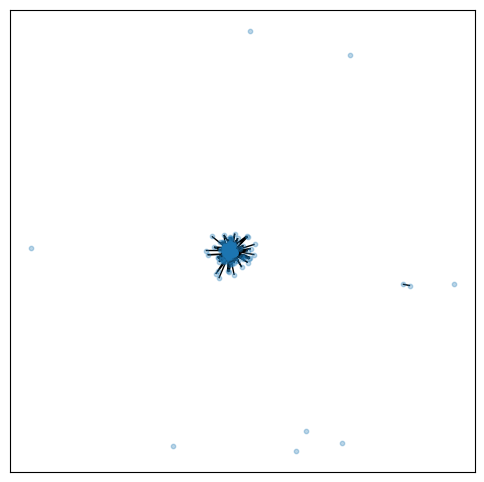

In [20]:
plot_graph(G)

In [17]:
idx = np.where(drugs_graph.sum(axis=1) > 1)[0]

dense_graph = drugs_graph[idx, :]
dense_graph = dense_graph[:, idx]

In [19]:
dense_graph.shape

(1083, 1083)

In [20]:
G = nx.Graph()
G.add_nodes_from(range(dense_graph.shape[0]))
G.add_edges_from( np.argwhere(dense_graph!=0) )

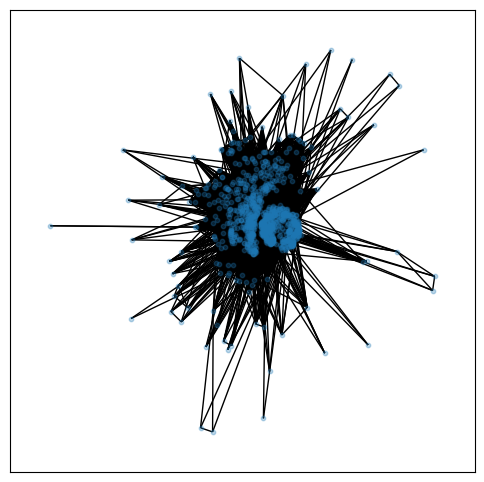

In [21]:
plot_graph(G)

## Create a graph in which nodes represent genes and edges represent  

In [213]:
genes = transpose(drugs)

In [214]:
genes_graph = build_graph_from_dict( genes )

  0%|          | 0/1244 [00:00<?, ?it/s]

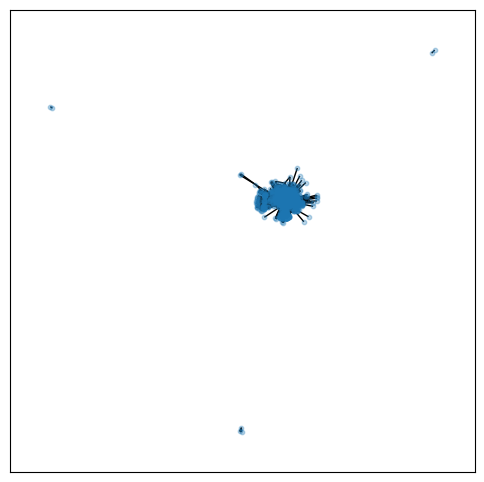

In [215]:
g=nx.Graph()
g.add_edges_from(np.argwhere(genes_graph!=0))
plot_graph(g)

In [218]:
idx_g = np.where(genes_graph.sum(axis=1) <= 1)

(array([ 327,  347,  368,  627,  629,  766,  836,  852,  893,  912,  939,
         946,  984,  993,  999, 1023, 1025, 1030, 1046, 1052, 1138, 1139,
        1140, 1194, 1197, 1199], dtype=int64),)

## Big Clam

- Hold out set de **Edges** 20% - verificar se o algoritmo consegue reconstruir as ligações eliminadas
- Avaliar os resultados através da cross-entropy entre a previsão e a matriz original
- Como descrito no algoritmo original do bigClam, o número de comunidades é selecionado a partir do resultado da avaliação no hold out set

In [18]:
NN = dense_graph.shape[0]

In [19]:
α = 1e-4
δ = np.sqrt(-np.log(1 - α))
δ

0.010000250013542027

In [20]:
node_pairs = set(
    list(
        map(lambda x: tuple(sorted(x)), np.argwhere(dense_graph!=0))
    )
)

In [21]:
node_pairs = np.array(
    list(map(list, node_pairs))
)

In [22]:
node_pairs.shape

(249608, 2)

In [23]:
#select the 20% edges to remove
N_out = int(len( node_pairs ) * 0.2)
node_pairs_idx = np.arange(len(node_pairs), dtype=int)

np.random.seed(1)
hold_out_idx = np.random.choice(node_pairs_idx, size=N_out, replace=False)

#hold_out_set = node_pairs[hold_out_idx]
mask = np.ones(dense_graph.shape)
for idx in hold_out_idx:
    i,j = node_pairs[idx]
    mask[i,j]=mask[j,i]=0
unmask=(mask+1)%2

In [24]:
#remove the edges in the graph used for training
dense_graph_train = dense_graph.copy()*mask

In [25]:
(dense_graph_train>0).sum()//2

199687

In [26]:
conns = {
    i : np.where(node_conns!=0)[0] for i, node_conns in enumerate(dense_graph_train)
}

In [154]:
k=10
MAX = None
F = get_F((NN, k))

ll_i=np.array(
    [log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(F.shape[0])]
).sum()
print("Initial Evaluation: ", ll_i)

Initial Evaluation:  -1971417.3435058189


In [155]:
ll_f = big_clam(conns, F, LR=0.00001, n_iters=15000, α=α, MAX_VALUE=MAX)
print("Final Evaluation: ", ll_f)

  0%|          | 0/8000 [00:00<?, ?it/s]

Final Evaluation:  335861.6641620734


In [27]:
ray.init()

2023-06-05 16:40:02,026	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.2.0


In [ ]:
ks = [2<<i for i in range(7, 0, -1)]
bc_results = run_bigClam(
    NN, ks, conns, (dense_graph>0)*1,
    mask=mask,n_iters=15000, LR=0.00001
)

(big_clam pid=20604) 64 communities -- iteration 0 finished
(big_clam pid=16972) 32 communities -- iteration 0 finished
(big_clam pid=14176) 128 communities -- iteration 0 finished
(big_clam pid=17060) 256 communities -- iteration 0 finished


In [ ]:
ray.shutdown()

In [39]:
bc_results

,initial_ll,final_ll,hold_out_ll,graph_ll
4,1.002787e+06,511592.438020,0.691096,0.414919
8,1.605411e+06,508458.765922,0.683598,0.409831
16,3.081950e+06,516252.454149,0.679258,0.413666


In [156]:
max_idx = np.argmax([log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(NN)])
max_idx

1002

In [157]:
ll_max = log_likelihood(F[max_idx], F.sum(axis=0), F[conns[max_idx]])
ll_max

-6.699586475066412

In [158]:
np.exp(ll_max)

0.00123142102069553

In [159]:
fc = F[conns[0]].T@((1-prob(F[0]@F[conns[0]].T))/prob(F[0]@F[conns[0]].T))

In [160]:
fnc = F.sum(axis=0) - F[0] - F[conns[0]].sum(axis=0)

In [161]:
np.round((fc - fnc), 2) * 0.01

array([-1.5629e+00, -1.0660e+00, -1.8420e-01, -1.4611e+00, -1.4421e+00,
        1.3000e-03, -2.1702e+00, -2.4497e+00, -5.1890e-01, -1.4206e+00])

In [162]:
np.round(F, 4)

array([[1.0000e-04, 1.0000e-04, 1.0000e-04, ..., 1.0000e-04, 1.0000e-04,
        1.0000e-04],
       [1.0000e-04, 1.0000e-04, 5.6900e-02, ..., 1.0000e-04, 1.0000e-04,
        1.0000e-04],
       [8.5600e-01, 1.0000e-04, 1.0000e-04, ..., 7.7460e-01, 1.0000e-04,
        7.6820e-01],
       ...,
       [2.5270e-01, 1.0000e-04, 1.0000e-04, ..., 6.2910e-01, 1.3530e-01,
        1.1054e+00],
       [1.0000e-04, 1.0000e-04, 1.0000e-04, ..., 1.0000e-04, 2.7470e-01,
        1.0000e-04],
       [1.0000e-04, 1.0000e-04, 2.1660e-01, ..., 1.0000e-04, 2.6190e-01,
        1.0000e-04]])

In [163]:
F.max(), F.min()

(2.129161698099278, 0.0001)

In [164]:
list(map(len, get_communities(F, δ).values()))

[519, 436, 460, 517, 341, 472, 531, 529, 565, 528]

In [43]:
from sklearn.metrics import mean_squared_error, log_loss

In [166]:
temp = get_graph_from_communities(F)

In [167]:
log_loss(
    (dense_graph>0)*1,
    temp
)

2989.3919887839056

In [168]:
log_loss(
    (dense_graph*unmask>0)*1,
    (temp*unmask),
    labels=(0,1)
)

0.4125578501704595

In [57]:
log_loss(np.ones(5), rand((5,), 0, .1), labels=(0,1))

4.306312953883531

In [74]:
t=rand((3,3), 0.0, 1)
t

array([[0.78728522, 0.40523148, 0.2629053 ],
       [0.38844466, 0.52593727, 0.43658643],
       [0.93230354, 0.89199781, 0.79435848]])

In [72]:
m=1*(rand((3,3), 0.0, 1)>0.5)
m

array([[1, 1, 1],
       [1, 1, 0],
       [0, 1, 0]])

In [107]:
log_loss(
    np.zeros((3,)),np.zeros((3,))+0.001, labels=(0,1)
)

0.0010005003335835344

In [75]:
tmask = np.zeros((3,3))
tmask[0,0]=1
tmask

array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])